In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

from transformers import pipeline

from scipy import stats

In [3]:
def process_batch(batchn):
    og_scores = list(pd.read_csv(f"../data/hatexplain_perspective/persp_score_original_{batchn}.csv")["score"])
    aave_scores = list(pd.read_csv(f"../data/hatexplain_perspective/persp_score_aave_{batchn}.csv")["score"])
    nigerianD_scores = list(pd.read_csv(f"../data/hatexplain_perspective/persp_score_nigerianD_{batchn}.csv")["score"])
    indianD_scores = list(pd.read_csv(f"../data/hatexplain_perspective/persp_score_indianD_{batchn}.csv")["score"])
    singlish_scores = list(pd.read_csv(f"../data/hatexplain_perspective/persp_score_singlish_{batchn}.csv")["score"])

    og_errors = json.load(open(f"../data/hatexplain_perspective/errors_original_{batchn}.json"))
    aave_errors = json.load(open(f"../data/hatexplain_perspective/errors_aave_{batchn}.json"))
    nigerianD_errors = json.load(open(f"../data/hatexplain_perspective/errors_nigerianD_{batchn}.json"))
    indianD_errors = json.load(open(f"../data/hatexplain_perspective/errors_indianD_{batchn}.json"))
    singlish_errors = json.load(open(f"../data/hatexplain_perspective/errors_singlish_{batchn}.json"))
            
    for idx in og_errors:
        og_scores.insert(idx, 0)    
    for idx in aave_errors:
        aave_scores.insert(idx, 0)
    for idx in nigerianD_errors:
        nigerianD_scores.insert(idx, 0)
    for idx in indianD_errors:
        indianD_scores.insert(idx, 0)
    for idx in singlish_errors:
        singlish_scores.insert(idx, 0)
    
    to_drop = sorted(list(set(og_errors + aave_errors + nigerianD_errors + indianD_errors + singlish_errors)), reverse=True)

    for idx in to_drop:
        del og_scores[idx]
        del aave_scores[idx]
        del nigerianD_scores[idx]
        del indianD_scores[idx]
        del singlish_scores[idx]

    return og_scores, aave_scores, nigerianD_scores, indianD_scores, singlish_scores, to_drop

In [4]:
og1, aave1, nigerianD1, indianD1, singlish1, to_drop1 = process_batch("batch1")
og2, aave2, nigerianD2, indianD2, singlish2, to_drop2 = process_batch("batch2")
og3, aave3, nigerianD3, indianD3, singlish3, to_drop3 = process_batch("batch3")
og4, aave4, nigerianD4, indianD4, singlish4, to_drop4 = process_batch("batch4")

In [5]:
og_scores = og1 + og2 + og3 + og4
aave_scores = aave1 + aave2 + aave3 + aave4
nigerianD_scores = nigerianD1 + nigerianD2 + nigerianD3 + nigerianD4
indianD_scores = indianD1 + indianD2 + indianD3 + indianD4
singlish_scores = singlish1 + singlish2 + singlish3 + singlish4

to_drop2 = [i+5000 for i in to_drop2]
to_drop3 = [i+10000 for i in to_drop3]
to_drop4 = [i+15000 for i in to_drop4]
to_drop = sorted(to_drop1 + to_drop2 + to_drop3 + to_drop4, reverse=True)

In [6]:
def check_increase_decrease(og_scores, converted_scores):
    increase = []
    decrease = []

    for i in range(len(og_scores)):
        if converted_scores[i] > og_scores[i]:
            increase.append((i, converted_scores[i] - og_scores[i]))
        elif converted_scores[i] < og_scores[i]:
            decrease.append((i, og_scores[i] - converted_scores[i]))

    return increase, decrease

In [7]:
aave_tox, og_tox = check_increase_decrease(og_scores, aave_scores)
print("dialect more toxic", len(aave_tox))
print("original more toxic", len(og_tox))

dialect more toxic 6560
original more toxic 11172


In [8]:
def get_rule_importance(converted_df, converted_scores, og_scores, to_drop):
    """
    Get the rules that are most likely to cause an increase or decrease in toxicity scores.

    converted_df: data frame containing synthetic sentences and the rules and they were applied on
    converted_scores: toxicity scores by PerspectiveAPI of the synthetic sentences
    og_scores: toxicity scores by PerspectiveAPI of the source sentences, len(og_scores) == len(converted_scores)
    to_drop: indexes of all sentences that were not processed by PerspectiveAPI
    """

    # drop all not processed documents from document list
    for idx in to_drop:
        converted_df.drop(idx, inplace=True)
    converted_df.reset_index(drop=True, inplace=True)

    # get indexes of increased and decreased instances
    converted_mtox, og_mtox = check_increase_decrease(og_scores, converted_scores)

    # seperate rules applied on instances with in-/decreased scores
    rules_increase_tox = []  # [[rule1, rule2, ...], [rule1, rule2, ...], ...]
    rules_decrease_tox = []  # [[rule1, rule2, ...], [rule1, rule2, ...], ...]

    # rules on instances for which toxicity increased
    for idx, score_change in converted_mtox:
        rules_increase_tox.append(converted_df["rules"][idx])
    # rules on instances for which toxicity decreased
    for idx, score_change in og_mtox:
        rules_decrease_tox.append(converted_df["rules"][idx])

    # how much did the scores in-/decreased
    increase_degree = [score_change for (idx, score_change) in converted_mtox]
    decrease_degree = [score_change for (idx, score_change) in og_mtox]

    # create rule_sentence_matrix, in which each row represnets a sentence
    # and each column represents a rule, like a bag of words matrix
    vectorizer = (
        CountVectorizer()
    )  # used for creating the rule_sentence_matrix, like BoW

    # convert rule list of each document to a single string for CountVectorizer()
    rules_increase_tox_as_strings = [" ".join(doc) for doc in rules_increase_tox]
    # learn the "vocabulary" dictionary and return term-document matrix
    X = vectorizer.fit_transform(rules_increase_tox_as_strings)
    rule_sent_matrix_increase = pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names_out()
    )

    # do the same for instances with decreased toxicity scores
    rules_decrease_tox_as_strings = [" ".join(doc) for doc in rules_decrease_tox]
    X = vectorizer.fit_transform(rules_decrease_tox_as_strings)
    rule_sent_matrix_decrease= pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names_out()
    )

    # test each rule vector against in-/decrease degree, see if the relevance is significant
    rules_cause_increase = []  # [{rule1_name, (r, p)}, {rule2_name, (r, p)} ...]

    for i in range(len(rule_sent_matrix_increase.columns)):
        column_name = rule_sent_matrix_increase.columns[i]

        # apply a statistic test
        r, p = stats.pointbiserialr(
            rule_sent_matrix_increase[column_name], increase_degree
        )
        if p < 0.05:
            significant = {column_name: (r, p)}
            rules_cause_increase.append(significant)

    rules_cause_increase = sorted(
        rules_cause_increase, key=lambda x: list(x.values())[0][1]
    )

    # do the same for instances with decreased toxicity scores
    rules_cause_decrease = []

    for i in range(len(rule_sent_matrix_decrease.columns)):
        column_name = rule_sent_matrix_decrease.columns[i]

        # apply a statistic test
        r, p = stats.pointbiserialr(
            rule_sent_matrix_decrease[column_name], decrease_degree
        )
        if p < 0.05:
            significant = {column_name: (r, p)}
            rules_cause_decrease.append(significant)

    rules_cause_decrease = sorted(
        rules_cause_decrease, key=lambda x: list(x.values())[0][1]
    )

    return rule_sent_matrix_increase, rules_cause_increase, rule_sent_matrix_decrease, rules_cause_decrease

In [25]:
increase_rull_all = []
decrease_rull_all = []

In [26]:
def print_relevant_rules(rules_cause_increase, rules_cause_decrease):
    rule_names_in = sorted([list(rule.keys())[0] for rule in rules_cause_increase])
    rule_names_de = sorted([list(rule.keys())[0] for rule in rules_cause_decrease])

    print("rules that cause increase in toxicity")
    print(len(rule_names_in), rule_names_in)
    print("rules that cause decrease in toxicity")
    print(len(rule_names_de), rule_names_de)

    # check how similar is the rule_names_in and rule_names_de
    print("rules found in both increase and decrease in toxicity")
    intersection = sorted(list(set(rule_names_in).intersection(set(rule_names_de))))
    print(len(intersection), intersection)

    return True

In [27]:
aave_full = pd.read_json("../data/hatexplain/aave_full.jsonl", lines=True)
(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(aave_full, aave_scores, og_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

increase_rull_all += rules_cause_increase
decrease_rull_all += rules_cause_decrease

rules that cause increase in toxicity
22 ['acomp_focusing_like', 'aint_be', 'bare_past_tense', 'chaining_main_verbs', 'clefting', 'demonstrative_for_definite_articles', 'do_tense_marker', 'double_modals', 'drop_copula_be_np', 'for_to', 'generalized_third_person_s', 'mass_noun_plurals', 'null_referential_pronouns', 'past_been', 'plural_to_singular_human', 'progressives', 'proximal_distal_demonstratives', 'referential_thing', 'regularized_plurals', 'she_inanimate_objects', 'to_infinitive', 'zero_plural']
rules that cause decrease in toxicity
28 ['aint_before_main', 'bare_past_tense', 'bare_perfect', 'clefting', 'completive_done', 'demonstrative_for_definite_articles', 'double_comparative', 'drop_aux_be_progressive', 'drop_copula_be_np', 'flat_adj_for_adv', 'for_to', 'future_sub_gon', 'generalized_third_person_s', 'mass_noun_plurals', 'null_genitive', 'null_relcl', 'plural_to_singular_human', 'progressives', 'proximal_distal_demonstratives', 'referential_thing', 'regularized_plurals', 're

In [28]:
nigerianD_full = pd.read_json("../data/hatexplain/nigerianD_full.jsonl", lines=True)
(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(nigerianD_full, nigerianD_scores, og_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

increase_rull_all += rules_cause_increase
decrease_rull_all += rules_cause_decrease

rules that cause increase in toxicity
10 ['demonstrative_no_number', 'drop_aux_be_progressive', 'drop_inf_to', 'null_prepositions', 'progressives', 'regularized_past_tense', 'regularized_plurals', 'remove_det_definite', 'to_infinitive', 'yall']
rules that cause decrease in toxicity
12 ['corr_conjunction_doubling', 'demonstrative_no_number', 'drop_inf_to', 'mass_noun_plurals', 'null_prepositions', 'present_for_exp_perfect', 'progressives', 'regularized_plurals', 'remove_det_definite', 'shadow_pronouns', 'to_infinitive', 'uninflect']
rules found in both increase and decrease in toxicity
7 ['demonstrative_no_number', 'drop_inf_to', 'null_prepositions', 'progressives', 'regularized_plurals', 'remove_det_definite', 'to_infinitive']


In [29]:
indianD_full = pd.read_json("../data/hatexplain/indianD_full.jsonl", lines=True)
(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(indianD_full, indianD_scores, og_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

increase_rull_all += rules_cause_increase
decrease_rull_all += rules_cause_decrease

rules that cause increase in toxicity
19 ['acomp_focusing_like', 'corr_conjunction_doubling', 'demonstrative_no_number', 'double_obj_order', 'fronting_pobj', 'indef_one', 'mass_noun_plurals', 'null_prepositions', 'null_referential_pronouns', 'null_relcl', 'object_pronoun_drop', 'plural_to_singular_human', 'present_perfect_for_past', 'progressives', 'remove_det_definite', 'remove_det_indefinite', 'shadow_pronouns', 'will_would', 'zero_plural']
rules that cause decrease in toxicity
30 ['acomp_focusing_like', 'definite_abstract', 'definite_for_indefinite_articles', 'demonstrative_for_definite_articles', 'double_comparative', 'drop_aux_be_progressive', 'drop_aux_have', 'existential_there', 'indef_one', 'indefinite_for_definite_articles', 'inverted_indirect_question', 'it_dobj', 'mass_noun_plurals', 'more_much', 'null_genitive', 'null_referential_pronouns', 'null_relcl', 'object_pronoun_drop', 'plural_to_singular_human', 'present_for_exp_perfect', 'present_modals', 'present_perfect_for_past

In [30]:
singlish_full = pd.read_json("../data/hatexplain/singlish_full.jsonl", lines=True)
(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(singlish_full, singlish_scores, og_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

increase_rull_all += rules_cause_increase
decrease_rull_all += rules_cause_decrease

rules that cause increase in toxicity
16 ['acomp_focusing_like', 'bare_past_tense', 'chaining_main_verbs', 'completive_finish', 'drop_aux_yn', 'drop_copula_be_ap', 'existential_got', 'give_passive', 'linking_relcl', 'mass_noun_plurals', 'null_prepositions', 'plural_to_singular_human', 'present_perfect_for_past', 'referential_thing', 'regularized_past_tense', 'remove_det_definite']
rules that cause decrease in toxicity
28 ['acomp_focusing_like', 'bare_past_tense', 'completive_finish', 'demonstrative_for_definite_articles', 'double_comparative', 'drop_aux_be_progressive', 'drop_aux_have', 'drop_aux_yn', 'drop_inf_to', 'existential_it', 'give_passive', 'indef_one', 'inverted_indirect_question', 'it_dobj', 'mass_noun_plurals', 'null_prepositions', 'null_referential_pronouns', 'object_pronoun_drop', 'plural_to_singular_human', 'present_for_exp_perfect', 'present_modals', 'present_perfect_for_past', 'progressives', 'referential_thing', 'regularized_past_tense', 'remove_det_definite', 'uninfl

In [42]:
Counter([list(rule.keys())[0] for rule in increase_rull_all]).most_common(10)

[('progressives', 3),
 ('mass_noun_plurals', 3),
 ('acomp_focusing_like', 3),
 ('plural_to_singular_human', 3),
 ('null_prepositions', 3),
 ('remove_det_definite', 3),
 ('chaining_main_verbs', 2),
 ('bare_past_tense', 2),
 ('null_referential_pronouns', 2),
 ('regularized_plurals', 2)]

In [32]:
Counter([list(rule.keys())[0] for rule in decrease_rull_all]).most_common(10)

[('progressives', 4),
 ('uninflect', 4),
 ('mass_noun_plurals', 4),
 ('demonstrative_for_definite_articles', 3),
 ('drop_aux_be_progressive', 3),
 ('plural_to_singular_human', 3),
 ('double_comparative', 3),
 ('remove_det_definite', 3),
 ('present_for_exp_perfect', 3),
 ('null_relcl', 2)]

In [ ]:
aave_full = pd.read_json("../data/hatexplain/aave_full.jsonl", lines=True)
for idx in to_drop:
    aave_full.drop(idx, inplace=True)
    aave_full.reset_index(drop=True, inplace=True)

In [151]:
rules_increased_tox = []
rules_decreased_tox = []

for (idx, score_change) in aave_tox:
    rules_increased_tox.append(aave_full["rules"][idx])
for (idx, score_change) in og_tox:
    rules_decreased_tox.append(aave_full["rules"][idx])

print(len(rules_increased_tox))
print(len(rules_decreased_tox))

6560
11172


In [152]:
increase_degree = [score_change for (idx, score_change) in aave_tox]
decrease_degree = [score_change for (idx, score_change) in og_tox]

In [153]:
# flat rules_incresed_tox
rules_increased_tox_flat = [item for sublist in rules_increased_tox for item in sublist]
rules_decreased_tox_flat = [item for sublist in rules_decreased_tox for item in sublist]
# count rules_increased_tox
rules_increased_tox_count = Counter(rules_increased_tox_flat)
rules_decreased_tox_count = Counter(rules_decreased_tox_flat)
print(rules_increased_tox_count)
print(rules_decreased_tox_count)

Counter({'demonstrative_for_definite_articles': 1703, 'yall': 1460, 'regularized_plurals': 1435, 'uninflect': 1380, 'mass_noun_plurals': 1312, 'zero_plural': 948, 'null_relcl': 852, 'bare_past_tense': 819, 'drop_copula_be_NP': 789, 'indef_one': 661, 'progressives': 661, 'plural_to_singular_human': 660, 'generalized_third_person_s': 650, 'aint_before_main': 607, 'drop_aux_be_progressive': 561, 'negative_concord': 554, 'referential_thing': 539, 'double_modals': 520, 'proximal_distal_demonstratives': 507, 'for_to': 497, 'do_tense_marker': 457, 'past_for_past_participle': 413, 'drop_copula_be_AP': 408, 'bare_perfect': 406, 'acomp_focusing_like': 403, 'clefting': 371, 'aint_be': 340, 'possessives_for_pre': 325, 'regularized_past_tense': 324, 'linking_relcl': 320, 'shadow_pronouns': 316, 'null_referential_pronouns': 316, 'double_comparative': 258, 'no_gender_distinction': 257, 'em_subj_pronoun': 237, 'past_been': 214, 'drop_aux_yn': 206, 'participle_past_tense': 200, 'plural_interrogative': 

In [155]:
# extract increase degree of the first ten documents
increase_degree = increase_degree

# extract rules applied on the first ten documents 
documents = rules_increased_tox

# Join the tokens into a single string for each document
documents = [' '.join(doc) for doc in documents]

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Learn the vocabulary dictionary and return term-document matrix
X = vectorizer.fit_transform(documents)

# Convert the matrix to a DataFrame
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [157]:
print(increase_degree)
print(df.shape)

# print column names of df
print(len(df.columns))

[0.009089769999999997, 0.03801739999999998, 0.00883510999999998, 0.014341570000000026, 0.04134330000000003, 0.04895963999999997, 0.002359570000000033, 0.01148884, 0.01001668, 0.035991159999999967, 0.016348769999999957, 0.0037847400000000087, 0.004738200000000026, 0.011696490000000004, 0.0019580099999999545, 0.0017992600000000247, 0.004525940000000062, 0.0010606279999999975, 0.02809222, 0.03726505999999996, 0.010727270000000066, 0.017664999999999986, 0.006862099999999982, 0.012755699999999981, 0.021856190000000053, 0.023967599999999978, 0.019393839999999996, 0.011336669999999993, 0.06810551999999992, 0.03530679999999997, 0.05605959999999999, 0.03359924999999997, 0.018657900000000005, 0.009476350000000022, 0.014845500000000067, 0.024875480000000005, 0.017735129999999988, 0.01400828000000004, 0.01571559999999994, 0.06324106000000007, 0.0007421719999999993, 0.037605, 0.07237009999999999, 0.00844986999999997, 0.022033359999999946, 0.010848329999999962, 0.02090852999999998, 0.027689189999999

In [186]:
results = []

for i in range(len(df.columns) - 1):
    column_name = df.columns[i]

    r, p = stats.pointbiserialr(df[column_name], df["increase_degree"])
    if p < 0.05:
        significant = {column_name: (r, p)}
        results.append(significant)

results = sorted(results, key=lambda x: list(x.values())[0][1])

## examine TwitterAAE results

### original WH vs. WH -> AAVE

In [12]:
wh_scores = list(pd.read_csv("../data/twitter_aae/persp_score_wh250.csv")["score"])
aave_scores = list(pd.read_csv("../data/twitter_aae/persp_score_aave250_synth.csv")["score"])

wh_errors = json.load(open(f"../data/twitter_aae/errors_wh250.json"))
aave_errors = json.load(open(f"../data/twitter_aae/errors_aave250_synth.json"))

to_drop = sorted(list(set(wh_errors + aave_errors)), reverse=True)

In [17]:
aave250_synth = pd.read_json("../data/twitter_aae/aave250_synth.jsonl", lines=True)

(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(aave250_synth, aave_scores, wh_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

2 ['aint_before_main', 'comparative_than']
3 ['aint_before_main', 'clefting', 'irrealis_be_done']
1 ['aint_before_main']


True

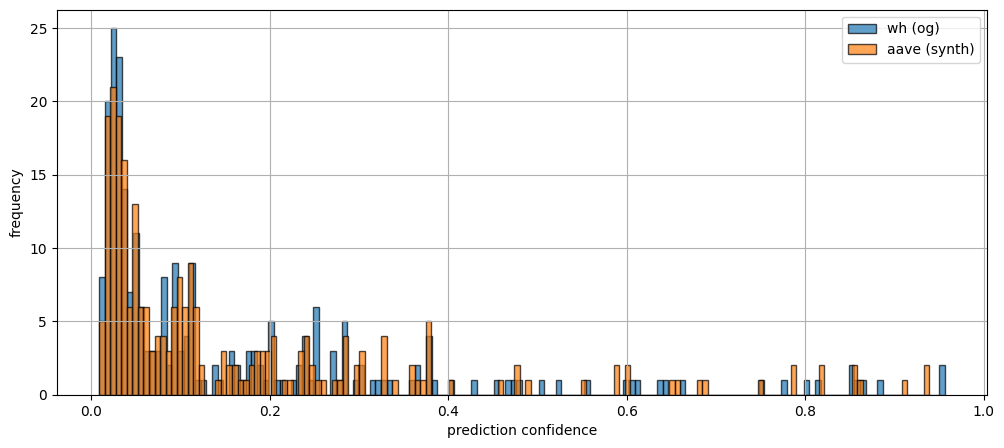

In [22]:
# plot prediction confidence of different dialects
plt.figure(figsize=(12, 5))

plt.hist(wh_scores, bins=150, edgecolor='black', alpha=0.7, label="wh (og)")
plt.hist(aave_scores, bins=150, edgecolor='black', alpha=0.7, label="aave (synth)")

plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

### original AA vs. AA -> CAD

In [18]:
aa_scores = list(pd.read_csv("../data/twitter_aae/persp_score_aa250.csv")["score"])
cad_scores = list(pd.read_csv("../data/twitter_aae/persp_score_cad250_synth.csv")["score"])

aa_errors = json.load(open(f"../data/twitter_aae/errors_aa250.json"))
cad_errors = json.load(open(f"../data/twitter_aae/errors_cad250_synth.json"))

to_drop = sorted(list(set(aa_errors + cad_errors)), reverse=True)

In [19]:
cad250_synth = pd.read_json("../data/twitter_aae/cad250_synth.jsonl", lines=True)

(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(cad250_synth, cad_scores, aa_scores, to_drop)

# decrease in toxicity: rules that de-toxified original AA250 texts
print_relevant_rules(rules_cause_increase, rules_cause_decrease)

2 ['em_subj_pronoun', 'proximal_distal_demonstratives']
1 ['zero_plural']
0 []


True

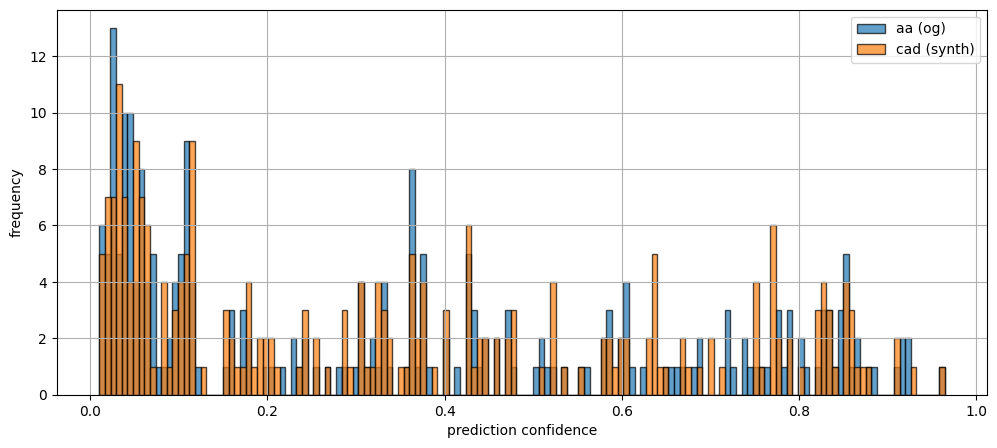

In [23]:
# plot prediction confidence of different dialects
plt.figure(figsize=(12, 5))

plt.hist(aa_scores, bins=150, edgecolor='black', alpha=0.7, label="aa (og)")
plt.hist(cad_scores, bins=150, edgecolor='black', alpha=0.7, label="cad (synth)")

plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()